# Data understanding and Exploratory analysis (EDA)
## Topic: Examining the ecological processes influencing the assembly of molecules into OM assemblages


Dataset: 2 March 2022 from GDrive
(1) CF for SED and Water: https://drive.google.com/drive/folders/1hm4YNib_kI5Y4k7xp4E47w8qDjUIsagA?usp=sharing
(2) Metadata:

## Data Processing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
fn_sed = "../Dataset/Sediment_Prevalence_10__commat_2021-09-29.csv"
fn_water = "../Dataset/Water_Prevalence_10__commat_2021-09-29.csv"
df_sed = pd.read_csv(fn_sed)
print('Sediment: ' + str(df_sed.shape))

df_water = pd.read_csv(fn_water)
print('Water: ' + str(df_water.shape))

# Data quality check
print(df_sed.columns.nunique())
print(df_water.columns.nunique())

# Check how many overlapping CF
print(len(set(df_sed.columns).intersection(set(df_water.columns))))

# Join datasets
df = pd.concat([df_sed, df_water], join="outer")
print(df.shape)

# Check if there is any identical columns / CF across all samples
print("Duplicated column: " + str(df.columns.duplicated().any()))

# Pre-processing
df = df.rename(columns={"Unnamed: 0": "sample_id"})
df = df.set_index("sample_id").fillna(0).reset_index()
df['type'] = df['sample_id'].str.split('_').str[0]
df['location'] = df['sample_id'].str.split('_').str[-2]
print(df.shape)
df.head()

Sediment: (239, 4053)
Water: (265, 4936)
4053
4936
2109
(504, 6880)
Duplicated column: False
(504, 6882)


,sample_id,C10H10O5,C10H10O5N4,C10H10O6,C10H10O6N4,C10H10O7,C10H10O8,C10H11O4N5,C10H11O5N,C10H11O5N5,...,C9H16O5S,C9H16O9N4S,C9H20O5NS2P,C9H7O5N,C9H7O6N,C9H8O6S,C9H8O8,C9H9O6N,type,location
0,SED_S19S.0001_D_Field,1,1.0,1,1.0,1,1,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SED,D
1,SED_S19S.0001_M_Field,1,1.0,1,1.0,1,1,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SED,M
2,SED_S19S.0001_U_Field,1,1.0,1,1.0,1,0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SED,U
3,SED_S19S.0003_D_Field,1,0.0,1,0.0,1,1,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SED,D
4,SED_S19S.0003_M_Field,1,0.0,0,0.0,0,0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SED,M


In [4]:
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['type','location']]).toarray())
encoder_df.columns = ['SED','SW','D','M','U']
#merge one-hot encoded columns back with original DataFrame
final_df = df.join(encoder_df).set_index('sample_id')
final_df.drop(['type', 'location'], axis='columns', inplace=True)
final_df = final_df.apply(pd.to_numeric).astype(int)
final_df.head()

,C10H10O5,C10H10O5N4,C10H10O6,C10H10O6N4,C10H10O7,C10H10O8,C10H11O4N5,C10H11O5N,C10H11O5N5,C10H11O6N,...,C9H7O5N,C9H7O6N,C9H8O6S,C9H8O8,C9H9O6N,SED,SW,D,M,U
sample_id,,,,,,,,,,,,,,,,,,,,,
SED_S19S.0001_D_Field,1,1,1,1,1,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
SED_S19S.0001_M_Field,1,1,1,1,1,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
SED_S19S.0001_U_Field,1,1,1,1,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
SED_S19S.0003_D_Field,1,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
SED_S19S.0003_M_Field,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [5]:
#final_df.to_csv('all.csv')

In [6]:
col = ['SED','SW','D','M','U']
final_df[col].value_counts()

SED  SW  D  M  U
0    1   0  0  1    265
1    0   0  1  0     83
            0  1     80
         1  0  0     76
dtype: int64

In [7]:
temp = final_df.groupby(col).sum().reset_index(drop=True).T
temp.head(5)

,0,1,2,3
C10H10O5,245,74,75,71
C10H10O5N4,0,60,63,53
C10H10O6,250,69,66,63
C10H10O6N4,0,42,41,40
C10H10O7,234,60,53,54


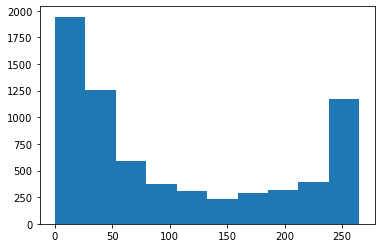

In [8]:
plt.hist(temp[0])
plt.show()

## Initial DOM cluster exploration using BM model

https://www.kaggle.com/code/allunia/uncover-target-correlations-with-bernoulli-mixture/notebook#How-can-we-uncover-hidden-protein-groups?

Shape:(265, 4935)


<AxesSubplot:>

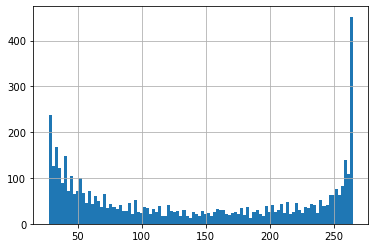

In [9]:
sw = pd.DataFrame(final_df[(final_df['SW']==1)].iloc[:,:-5])
sw = sw.loc[:, (sw != 0).any(axis=0)]
print("Shape:" + str(sw.shape))
sw.sum().hist(bins=100)

In [10]:
sw.sum().value_counts().sort_index(ascending=False).head(20)

265    240
264    132
263     80
262     61
261     48
260     50
259     45
258     44
257     38
256     44
255     39
254     23
253     23
252     29
251     23
250     32
249     31
248     19
247     27
246     16
dtype: int64

In [11]:
sw.sum().value_counts().sort_index(ascending=True).head(20)

27    75
28    90
29    72
30    71
31    55
32    55
33    60
34    53
35    58
36    63
37    42
38    48
39    43
40    55
41    51
42    28
43    43
44    44
45    28
46    32
dtype: int64

In [12]:
sw.sum().min()

27

In [13]:
# CF to be dropped due to high appearance
threshold = 264
to_remove = (sw.sum() >= threshold)
cols_to_drop = to_remove[to_remove].index
print(str(len(cols_to_drop)) + " CF appear in almost all sample, to be removed.")
sw = sw.drop(cols_to_drop, axis=1)
sw.shape

372 CF appear in almost all sample, to be removed.


(265, 4563)

## Bernoulli Mixture Model

In [14]:
from scipy.special import logsumexp

class BernoulliMixture:
    
    def __init__(self, n_components, max_iter, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
    
    def fit(self,x):
        self.x = x
        self.init_params()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.old_logL = self.get_log_likelihood(log_bernoullis)
        for step in range(self.max_iter):
            if step > 0:
                self.old_logL = self.logL
            # E-Step
            self.gamma = self.get_responsibilities(log_bernoullis)
            self.remember_params()
            # M-Step
            self.get_Neff()
            self.get_mu()
            self.get_pi()
            # Compute new log_likelihood:
            log_bernoullis = self.get_log_bernoullis(self.x)
            self.logL = self.get_log_likelihood(log_bernoullis)
            if np.isnan(self.logL):
                self.reset_params()
                print(self.logL)
                break

    def reset_params(self):
        self.mu = self.old_mu.copy()
        self.pi = self.old_pi.copy()
        self.gamma = self.old_gamma.copy()
        self.get_Neff()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.logL = self.get_log_likelihood(log_bernoullis)
        
    def remember_params(self):
        self.old_mu = self.mu.copy()
        self.old_pi = self.pi.copy()
        self.old_gamma = self.gamma.copy()
    
    def init_params(self):
        self.n_samples = self.x.shape[0]
        self.n_features = self.x.shape[1]
        #self.gamma = np.zeros(shape=(self.n_samples, self.n_components))
        self.pi = 1/self.n_components * np.ones(self.n_components)
        self.mu = np.random.RandomState(seed=0).uniform(low=0.25, high=0.75, size=(self.n_components, self.n_features))
        self.normalize_mu()
    
    def normalize_mu(self):
        sum_over_features = np.sum(self.mu, axis=1)
        for k in range(self.n_components):
            self.mu[k,:] /= sum_over_features[k]
            
    def get_responsibilities(self, log_bernoullis):
        gamma = np.zeros(shape=(log_bernoullis.shape[0], self.n_components))
        Z =  logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
        for k in range(self.n_components):
            gamma[:, k] = np.exp(np.log(self.pi[k]) + log_bernoullis[:,k] - Z)
        return gamma
        
    def get_log_bernoullis(self, x):
        log_bernoullis = self.get_save_single(x, self.mu)
        log_bernoullis += self.get_save_single(1-x, 1-self.mu)
        return log_bernoullis
    
    def get_save_single(self, x, mu):
        mu_place = np.where(np.max(mu, axis=0) <= 1e-15, 1e-15, mu)
        return np.tensordot(x, np.log(mu_place), (1,1))
        
    def get_Neff(self):
        self.Neff = np.sum(self.gamma, axis=0)
    
    def get_mu(self):
        self.mu = np.einsum('ik,id -> kd', self.gamma, self.x) / self.Neff[:,None] 
        
    def get_pi(self):
        self.pi = self.Neff / self.n_samples
    
    def predict(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        gamma = self.get_responsibilities(log_bernoullis)
        return np.argmax(gamma, axis=1)
        
    def get_sample_log_likelihood(self, log_bernoullis):
        return logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
    
    def get_log_likelihood(self, log_bernoullis):
        return np.mean(self.get_sample_log_likelihood(log_bernoullis))
        
    def score(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_log_likelihood(log_bernoullis)
    
    def score_samples(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_sample_log_likelihood(log_bernoullis)

In [15]:
from sklearn.model_selection import train_test_split

X = sw.values
x_train, x_test = train_test_split(X, shuffle=True, random_state=0)

In [16]:
len(x_train)

198

In [17]:
components_to_test = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

In [18]:
np.seterr(divide = 'ignore') 

scores = []

for n in range(len(components_to_test)):
    if n > 0:
        old_score = score
    model = BernoulliMixture(components_to_test[n], 200)
    model.fit(x_train)
    score = model.score(x_test)
    scores.append(score)
    if n > 0: 
        if score < old_score:
            estimated_components = components_to_test[n-1]
            break

-2037.175421444951
-1994.6019942905382
-1940.521590376574
-1912.1137679226495
-19265.27041925591


In [19]:
estimated_components

5

In [20]:
# Set max iter 200
model = BernoulliMixture(estimated_components, 200)
model.fit(X)

-1927.5917655926241


In [21]:
results = sw.copy()
results["cluster"] = np.argmax(model.gamma, axis=1)

In [22]:
results["cluster"].value_counts()

4    112
0     55
2     47
1     36
3     15
Name: cluster, dtype: int64

C:\Users\mchang\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

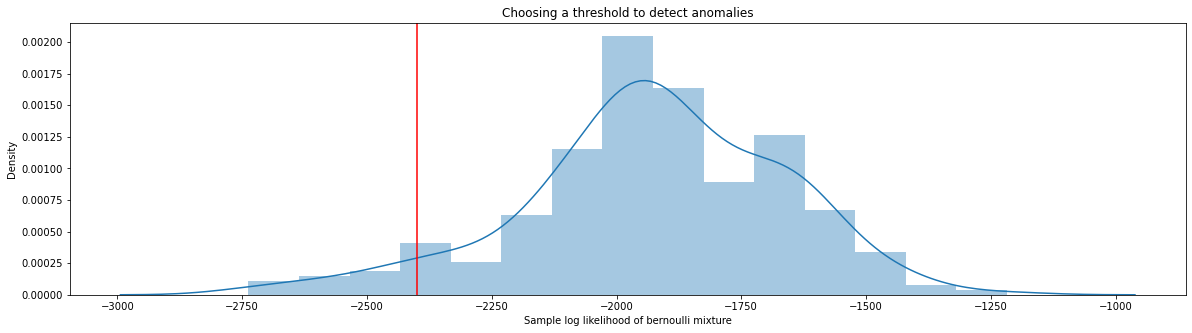

In [27]:
sample_logLs = model.score_samples(X)
my_threshold = np.quantile(sample_logLs, 0.05)
plt.figure(figsize=(20,5))
sns.distplot(sample_logLs)
plt.axvline(my_threshold, color="Red")
plt.xlabel("Sample log likelihood of bernoulli mixture")
plt.title("Choosing a threshold to detect anomalies")
plt.ylabel("Density")

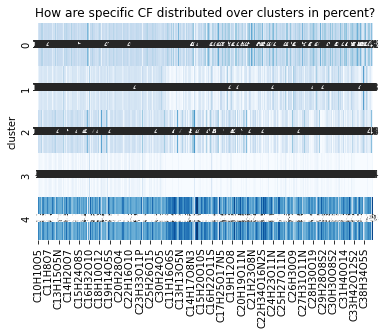

In [38]:
# Plot graph
grouped_targets = results.groupby("cluster").sum() / results.drop("cluster", axis=1).sum(axis=0) * 100
grouped_targets = grouped_targets.apply(np.round).astype(np.int32)

plt.figure(figsize=(20,15))
sns.heatmap(grouped_targets, cmap="Blues", annot=True, fmt="g", cbar=False);
plt.title("How are specific CF distributed over clusters in percent?");

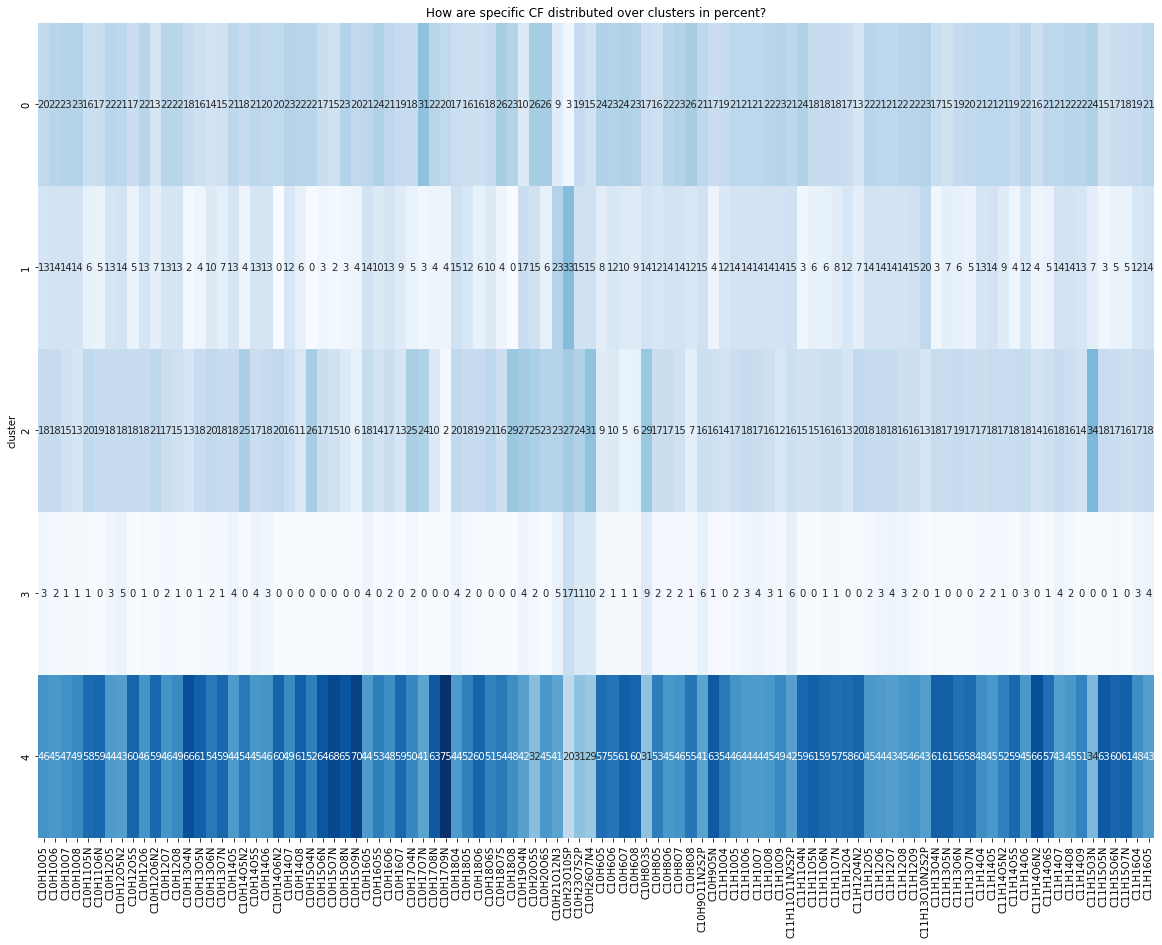

In [46]:
# Plot graph
grouped_targets = results.groupby("cluster").sum() / results.drop("cluster", axis=1).sum(axis=0) * 100
grouped_targets = grouped_targets.apply(np.round).astype(np.int32)

plt.figure(figsize=(20,15))
sns.heatmap(grouped_targets.iloc[:,:100], cmap="Blues", annot=True, fmt="g", cbar=False);
plt.title("How are specific CF distributed over clusters in percent?");

In [31]:
cluster_counts = results.groupby("cluster").cluster.count()
cluster_counts = cluster_counts.sort_values()

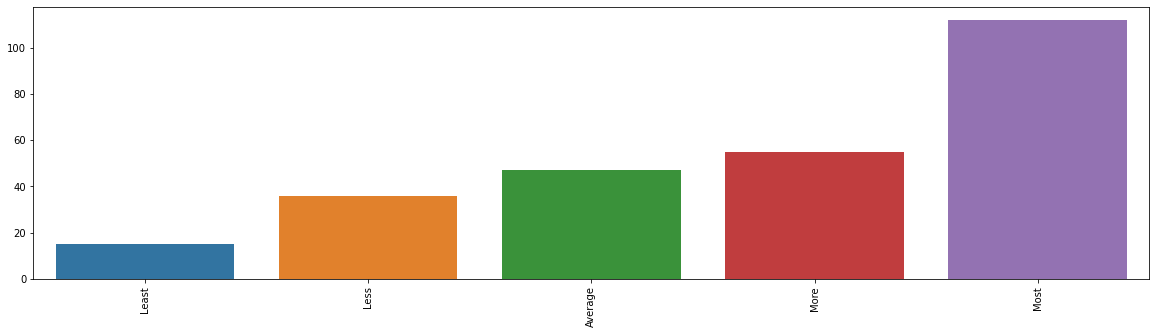

In [32]:
cluster_names = {
    0: "More",
    1: "Less",
    2: "Average",
    3: "Least",
    4: "Most"}
names = [cluster_names[num] for num in cluster_counts.index]

plt.figure(figsize=(20,5))
sns.barplot(x=names, y=cluster_counts.values, order=names)
plt.xticks(rotation=90);

C:\Users\mchang\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


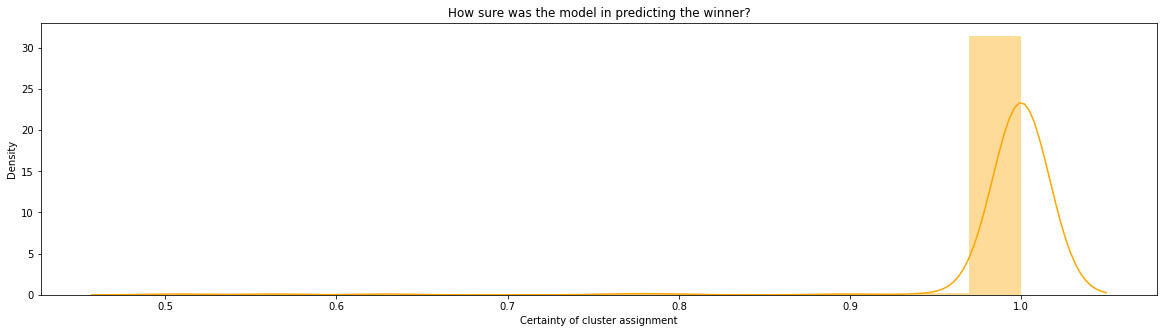

In [36]:
results["certainty"] = np.sort(model.gamma, axis=1)[:,-1]
certainties = results.certainty.values

plt.figure(figsize=(20,5))
sns.distplot(certainties, color="Orange")
plt.xlabel("Certainty of cluster assignment")
plt.ylabel("Density")
plt.title("How sure was the model in predicting the winner?");

In [25]:
# label cluster
results["BMM_label"] = np.nan
results.loc[results["cluster"] == 3, "BMM_label"] = "Least"
results.loc[results["cluster"] == 1, "BMM_label"] = "Less"
results.loc[results["cluster"] == 2, "BMM_label"] = "Average"
results.loc[results["cluster"] == 0, "BMM_label"] = "More"
results.loc[results["cluster"] == 4, "BMM_label"] = "Most"

In [26]:
results

,C10H10O5,C10H10O6,C10H10O7,C10H10O8,C10H11O5N,C10H11O6N,C10H12O5,C10H12O5N2,C10H12O5S,C10H12O6,...,C9H16O5S,C9H16O9N4S,C9H20O5NS2P,C9H7O5N,C9H7O6N,C9H8O6S,C9H8O8,C9H9O6N,cluster,BMM_label
sample_id,,,,,,,,,,,,,,,,,,,,,
SW_S19S.0003_U_1,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0,More
SW_S19S.0003_U_2,1,1,1,1,1,1,1,1,0,1,...,0,1,0,0,0,0,0,1,0,More
SW_S19S.0003_U_3,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,1,4,Most
SW_S19S.0004_U_1,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,1,4,Most
SW_S19S.0004_U_2,1,1,1,1,1,1,1,1,0,1,...,0,1,0,1,0,0,1,1,4,Most
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SW_S19S.0099_U_1,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,0,0,1,2,Average
SW_S19S.0099_U_2,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,0,1,0,More
SW_S19S.0099_U_3,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,0,1,2,Average


In [27]:
# temp = results.groupby("cluster").any()
# temp.sum(axis=1)

## Remove CF that appears in ALL clusters
# temp[temp>0] = 1
# temp = temp.loc[:, (temp == 0).any(axis=0)]
# temp.head()

# temp = results.groupby("cluster").sum()
# temp.head()

In [29]:
## Merge with knn clustering results
temp = pd.read_csv("knn.csv")
temp.head()

,sample_id,C10H10O5,C10H10O6,C10H10O7,C10H10O8,C10H11O5N,C10H11O6N,C10H12O5,C10H12O5N2,C10H12O5S,...,C9H16O5S,C9H16O9N4S,C9H20O5NS2P,C9H7O5N,C9H7O6N,C9H8O6S,C9H8O8,C9H9O6N,cluster,KNN_label
0,SW_S19S.0003_U_1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,1,3,Most
1,SW_S19S.0003_U_2,1,1,1,1,1,1,1,1,0,...,0,1,0,0,0,0,0,1,3,Most
2,SW_S19S.0003_U_3,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,3,Most
3,SW_S19S.0004_U_1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,3,Most
4,SW_S19S.0004_U_2,1,1,1,1,1,1,1,1,0,...,0,1,0,1,0,0,1,1,3,Most


In [30]:
df_merged = pd.merge(results.reset_index(), temp[["sample_id","KNN_label"]], on="sample_id", how="left")
df_merged.head()

,sample_id,C10H10O5,C10H10O6,C10H10O7,C10H10O8,C10H11O5N,C10H11O6N,C10H12O5,C10H12O5N2,C10H12O5S,...,C9H16O9N4S,C9H20O5NS2P,C9H7O5N,C9H7O6N,C9H8O6S,C9H8O8,C9H9O6N,cluster,BMM_label,KNN_label
0,SW_S19S.0003_U_1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,1,1,0,More,Most
1,SW_S19S.0003_U_2,1,1,1,1,1,1,1,1,0,...,1,0,0,0,0,0,1,0,More,Most
2,SW_S19S.0003_U_3,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,4,Most,Most
3,SW_S19S.0004_U_1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,4,Most,Most
4,SW_S19S.0004_U_2,1,1,1,1,1,1,1,1,0,...,1,0,1,0,0,1,1,4,Most,Most


In [31]:
df_merged[df_merged["BMM_label"] == df_merged["KNN_label"]]

,sample_id,C10H10O5,C10H10O6,C10H10O7,C10H10O8,C10H11O5N,C10H11O6N,C10H12O5,C10H12O5N2,C10H12O5S,...,C9H16O9N4S,C9H20O5NS2P,C9H7O5N,C9H7O6N,C9H8O6S,C9H8O8,C9H9O6N,cluster,BMM_label,KNN_label
2,SW_S19S.0003_U_3,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,4,Most,Most
3,SW_S19S.0004_U_1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,4,Most,Most
4,SW_S19S.0004_U_2,1,1,1,1,1,1,1,1,0,...,1,0,1,0,0,1,1,4,Most,Most
5,SW_S19S.0004_U_3,1,1,1,1,1,1,1,1,0,...,0,0,0,1,0,1,0,4,Most,Most
8,SW_S19S.0005_U_3,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,1,1,0,More,More
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,SW_S19S.0097_U_2,1,1,1,1,1,1,1,1,0,...,0,1,0,0,0,0,1,4,Most,Most
257,SW_S19S.0098_U_1,1,1,0,0,1,1,1,1,0,...,0,0,1,0,0,0,1,2,Average,Average
258,SW_S19S.0098_U_2,1,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,2,Average,Average
261,SW_S19S.0099_U_2,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,0,1,0,More,More


In [32]:
# only half overlapping

In [33]:
df_merged.to_csv("interim_clustering_results.csv")